# **Save this file as studentid1_studentid2_lab2.ipynb**, please check this suffix when you upload your lab, especially when you have multiple copy's in the same folder!
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Nikita Tokovenko"
NAME2 = "Volodymyr Medentsiy"
NAME3 = ""
EMAIL = "nikita.tokovenko@student.uva.nl"
EMAIL2 = "volodymyr.medentsiy@student.uva.nl"
EMAIL3 = ""

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

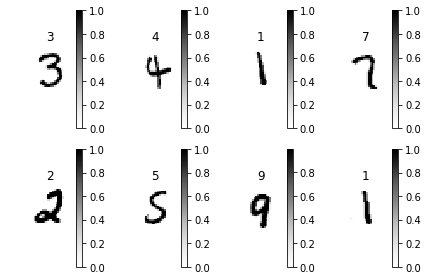

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&=
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 
\end{align}
#### YOUR ANSWER HERE


$$\frac{\partial \log Z}{\partial \ Z} = \frac{1}{Z}$$

$$\frac{\partial Z}{\partial \log q_{j}} = \frac{\partial \sum_{k}{q_k}}{\partial \log q_j} = \frac{\partial \sum_{k}{\exp(\log q_k)}}{\partial \log q_j} = \exp(\log q_j) = q_j$$

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_j}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 0 - \frac{q_j}{Z}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

#### YOUR ANSWER HERE

$$\frac{\partial \log q_j}{\partial W_{ij}} = \frac{\partial(\bw_j^T\bx + b_j)}{\partial W_{ij}} = \frac{\partial(\sum_{i}{W_{ij}x_i} + b_j)}{\partial W_{ij}} = x_i $$

$$\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \mathbf{\delta}_j^q x_i$$

$$\bx \in \mathbb{R}^{M}$$
$$\nabla_{\bw_j} \mathcal{L}^{(n)} = \mathbf{\delta}_j^q \bx^T\in \mathbb{R}^{1 \times M}, \textrm{ if using the lectures notation}$$ 

$$\nabla_{\bw_j} \mathcal{L}^{(n)} = \bx\mathbf{\delta}_j^q \in \mathbb{R}^{M \times 1}, \textrm{ if using the notation as earlier in this lab for calculating } \nabla_\bb \mathcal{L}^{(n)}$$ 

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    
    # YOUR CODE HERE
    logq = np.dot(x, w) + b
    logz = np.max(logq) + np.log(np.sum(np.exp(logq - np.max(logq)), axis = 1))
    logp = logq - logz
    delta = - np.exp(logq)/np.exp(logz) 
    delta[:, t] = 1 - np.exp(logq)[:, t]/np.exp(logz)
    dL_db = delta
    dL_dw = np.dot(delta.T, x).T

    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10
    
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.3612946893e-07
Finite difference error grad_b: 5.23511748609e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    # YOUR CODE HERE
    learning_rate = 1e-4
    M = x_train.shape[1]
    logp_train = np.zeros(len(x_train))
    order = np.arange(len(x_train))
    np.random.shuffle(order)
    for i in order:
        logp_train[i], dL_dw, dL_db = logreg_gradient(x_train[i].reshape((1, M)), t_train[i], W, b)
        W += learning_rate * dL_dw
        b += learning_rate * dL_db
    logp_train = np.mean(logp_train)
    return logp_train, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

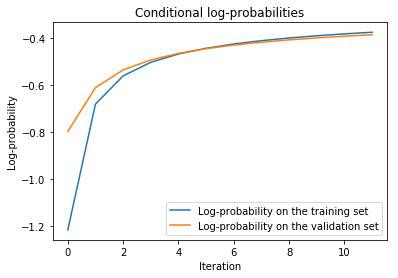

In [14]:
def validate(x_valid, t_valid, w, b):
    order = np.arange(x_valid.shape[0])
    np.random.shuffle(order)
    logp_valid = []
    for i in order:
        t = t_valid[i].reshape((1,))
        x = x_valid[i, :].reshape((1, x_valid.shape[1]))
        logq = np.dot(x, w) + b
        logz = np.max(logq) + np.log(np.sum(np.exp(logq - np.max(logq)), axis = 1))
        logp = logq - logz
        logp_valid.append(logp[:,t].squeeze())
    return mean(logp_valid)


def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    # YOUR CODE HERE
    logp_train = []
    logp_valid = []
    i = 0
    eps = 0.007
    while i < 2 or np.abs(logp_train[i - 1] - logp_train[i - 2]) > eps:
        logp_tr, w, b = sgd_iter(x_train, t_train, w, b)
        logp_val = validate(x_valid, t_valid, w, b)
        logp_train.append(logp_tr)
        logp_valid.append(logp_val)
        i += 1
    plt.plot(np.arange(i), logp_train, label = 'Log-probability on the training set')
    plt.title('Conditional log-probabilities')
    plt.plot(np.arange(i), logp_valid, label = 'Log-probability on the validation set')
    plt.legend(loc='lower right')
    plt.xlabel('Iteration')
    plt.ylabel('Log-probability');
    return w, b    
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


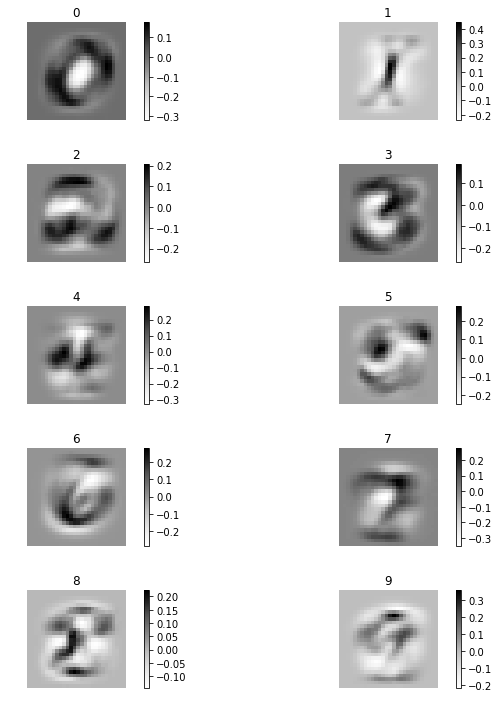

In [16]:
# YOUR CODE HERE
def plot_w_weights(data, num_cols, shape=(28,28)):
    num_rows = 5
    num_digits = 10
    plt.figure(figsize=(10, 10))
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1 )
        plt.imshow(data[:, i].reshape(shape), interpolation='none', cmap='Greys')
        plt.colorbar()
        plt.axis('off')
        plt.title(i)
        
    plt.tight_layout()
    plt.show()
    

plot_w_weights(w, num_cols = 2,shape=(28,28))

**Describe in less than 100 words why these weights minimize the loss**
#### YOUR ANSWER HERE

Giving the high weight to a particular pixel can be considered as treating this pixel as the one which can give us more information about the real label of the image. Thus, weights represent the most probable pattern for each class. In most cases, it can be clearly seen how the highest weights values are assigned to those pixels, which position corresponds to the position of black pixels of common representatives of each class. So by assigning the highest weights to the components which appear to be the most important in the terms of reconstructing the pattern you get more accurate predictions, so minimizing the loss - maximizing the log-likelihood.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


In [17]:
# YOUR CODE HERE
log_prob = np.zeros(x_valid.shape[0])
for i in range(x_valid.shape[0]):
    log_prob[i] = validate(x_valid[i:(i+1), :], t_valid[i:(i+1)], w, b)
    
lowest = log_prob.argsort()[:8]
highest = log_prob.argsort()[-8:]

Digits with the highest probability


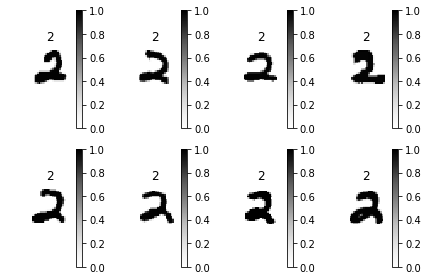

In [18]:
print('Digits with the highest probability')
plot_digits(x_valid[highest,:], num_cols = 4, targets=t_valid[highest], shape=(28,28))

Digits with the lowest probability


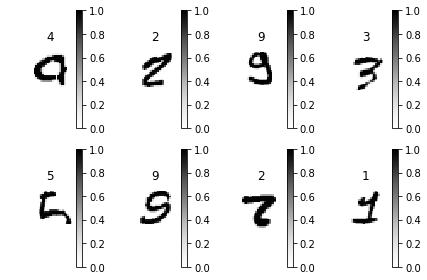

In [19]:
print('Digits with the lowest probability')
plot_digits(x_valid[lowest,:], num_cols = 4, targets=t_valid[lowest], shape=(28,28))

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

#### YOUR ANSWER HERE

These digits are hard to classify because the pictures seem to be unclear and vague even for humans (at least for us) and thus hard to classify. It means that the algorithm is very "unsure" about the class it predicts and assigns a relatively low probability.

In [20]:
print('The lowest probabilities are ',np.exp(log_prob[lowest]))

The lowest probabilities are  [  1.43061676e-06   7.68127713e-05   2.78917176e-04   5.17924535e-04
   7.63460869e-04   7.71073102e-04   1.03085722e-03   1.24033943e-03]


# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

#### YOUR ANSWER HERE
$\nabla_{\bb} \mathcal{L}^{(n)}$ remains the same because derivation of the softmax function w.r.t to the bias term couldn't be affected by the form of the feature vectors (changing $\bx$ by $\bh$ is not principle in terms of derivation)

$\nabla_{b_j} \mathcal{L}^{(n)} = \frac{\partial \mathcal{L}^{(n)}}{\partial b_j} = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial b_j} = \delta^q_j \cdot 1 = \delta^q_j$ 

$\nabla_{\bb} \mathcal{L}^{(n)} = \delta^q \in \mathbb{R}^{10 \times 1}$

$\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case, because the only difference we get is the change of $\bx$ by $\bh$, so also changing the shape of the gradient

$\nabla_{\bw_j} \mathcal{L}^{(n)} = \bh\mathbf{\delta}_j^q \in \mathbb{R}^{L \times 1}$

$\nabla_{\bW} \mathcal{L}^{(n)} = \bh(\mathbf{\delta}^{q})^{T} \in \mathbb{R}^{L \times 10}$

$\mathbf{\delta}^h_j = \frac{\partial L^{(n)}}{\partial h_j} = \sum_{i=1}^{10}\frac{\partial L^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial h_j} = \sum_{i=1}^{10}\mathbf{\delta}^q_i \bw_{ji} = \mathbf{\delta}^q \bw_j^T$

$\mathbf{\delta}^h = \bW \mathbf{\delta}^q$

$\nabla_{a_j} \mathcal{L}^{(n)} = \frac{\partial L^{(n)}}{\partial h_j} \frac{\partial h_j}{\partial a_j} = \mathbf{\delta}^h_j h_j(1-h_j)\cdot 1$

$\nabla_{a} \mathcal{L}^{(n)} = \mathbf{\delta}^h \times \bh(1-\bh)$ - element-wise multiplication 

$\nabla_{a} \mathcal{L}^{(n)} \in \mathbb{R}^{L \times 1}$

$\nabla_{v_j} \mathcal{L}^{(n)} = \frac{\partial L^{(n)}}{\partial h_j} \frac{\partial h_j}{\partial v_j} = \mathbf{\delta}^h_j h_j(1-h_j) \bx^T$

$\nabla_{v} \mathcal{L}^{(n)} = \bx (\mathbf{\delta}^h \times \bh(1-\bh))^T$

$\nabla_{v} \mathcal{L}^{(n)} \in \mathbb{R}^{784 \times L}$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

#### YOUR ANSWER HERE
Instead of maximizing the likelihood we need to maximize the posterior distribution of the weights. By introducing a gausian prior p(w) and applying bayesian rule we can obtain the solution as : w = argmax(log(Likelihood) + log(p(w))), so then the derivative of the log(p(w)) will also be taken into an account while optimizing. This will produce regularized version of the mle solution.

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [21]:
# Write all helper functions here
# YOUR CODE HERE
def sigmoid(x):
    return 1 / (1 + np.exp(-x) )
    
def dsigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def gradMLP(x, t, w, b, v, a):
    h = sigmoid(np.dot(x, v) + a)
    logq = np.dot(h, w) + b
    logz = np.max(logq) + np.log(np.sum(np.exp(logq - np.max(logq)), axis = 1))
    logp = logq - logz
    delta = - np.exp(logq)/np.exp(logz) 
    delta[:, t] = 1 - np.exp(logq)[:, t]/np.exp(logz)
    delta_h = np.dot(w, delta.T)
    t2 = np.dot(x.T, dsigmoid(np.dot(x, v) + a)).T
    dL_dv = np.multiply(delta_h, t2).T
    dL_da = np.multiply(delta_h.T, dsigmoid(np.dot(x, v) + a)).T
    dL_db = delta
    dL_dw = np.dot(delta.T, h).T
    return logp[:,t].squeeze(), dL_dv, dL_da.squeeze(), dL_dw, dL_db.squeeze()

def sgd_iter(x_train, t_train, W, b, V, a, eta = 1e-4):
    order = np.arange(x_train.shape[0])
    np.random.shuffle(order)
    logp_train = np.zeros(len(order))
    for i in order:
        logp_train[i], dL_dv, dL_da, dL_dw, dL_db = gradMLP(x_train[i, :].reshape((1, x_train.shape[1])), t_train[i].reshape((1, )), W, b, V, a)
        W = W + np.dot(dL_dw, eta)
        b = b + np.dot(dL_db, eta)
        V = V + np.dot(dL_dv, eta)
        a = a + np.dot(dL_da, eta)
    return logp_train.mean(), W, b, V, a

In [22]:
np.random.seed(1243)

v = np.random.normal(size=(28*28,20), scale=0.1)
a = np.random.normal(size=(20, ), scale=0.1)
w = np.random.normal(size=(20,10), scale=0.1)
b = np.random.normal(size=(10, ), scale=0.1)

def func(v):
    logpt, _, _, _, _ = gradMLP(x_train[0:1,:], t_train[0:1], w, b, v.reshape(784,20), a)
    return logpt
def grad(v):
    _, grad_v, _, _, _ = gradMLP(x_train[0:1,:], t_train[0:1], w, b, v.reshape(784,20), a)
    return grad_v.flatten()


finite_diff_error = check_grad(func, grad, v.flatten())
print('Finite difference error grad_v:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for v seems off'


def func(a):
    logp, _, _, _, _ = gradMLP(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return logp
def grad(a):
    _, _, grad_a, _, _ = gradMLP(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return grad_a.flatten()

finite_diff_error = check_grad(func, grad, a)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for a seems off'


def func(w):
    logpt, _, _, _, _ = gradMLP(x_train[0:1,:], t_train[0:1], w.reshape(20, 10), b, v.reshape(784,20), a)
    return logpt
def grad(w):
    _, _, _, grad_w, _ = gradMLP(x_train[0:1,:], t_train[0:1], w.reshape(20, 10), b, v.reshape(784,20), a)
    return grad_w.flatten()


finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'


def func(b):
    logp, _, _, _, _ = gradMLP(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return logp
def grad(b):
    _, _, _, _, grad_b = gradMLP(x_train[0:1,:], t_train[0:1], w, b, v, a)
    return grad_b.flatten()

finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'

Finite difference error grad_v: 9.23239895796e-07
Finite difference error grad_b: 9.28938784956e-08
Finite difference error grad_w: 1.745066448e-07
Finite difference error grad_b: 4.05625393526e-08


In [25]:
# Hidden tests for efficiency

In [26]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# Plot the weights of the first layer.

# 

# YOUR CODE HERE
def validate(x_valid, t_valid, w, b, v, a, eta):
    order = np.arange(x_valid.shape[0])
    np.random.shuffle(order)
    logp_valid = []
    for i in order:
        t = t_valid[i].reshape((1, ))
        x = x_valid[i, :].reshape((1, x_valid.shape[1]))
        h = sigmoid(np.dot(x, v) + a)
        logq = np.dot(h, w) + b
        logz = np.max(logq) + np.log(np.sum(np.exp(logq - np.max(logq)), axis = 1))
        logp = logq - logz
        logp_valid.append(logp[:,t].squeeze())
    return mean(logp_valid)

def test_sgd(x_train, t_train, x_valid, t_valid, w, b, v, a, eta = 1e-4):
    logp_train = []
    logp_valid = []
    i = 0
    while i < 10:
        logp_tr, w, b, v, a = sgd_iter(x_train, t_train, w, b, v, a, eta)
        logp_val = validate(x_valid, t_valid, w, b, v, a, eta)
        logp_train.append(logp_tr)
        logp_valid.append(logp_val)
        i += 1
    return w, b, v, a, logp_train, logp_valid

np.random.seed(1243)
v = np.random.normal(size=(28*28,20), scale=0.1)
a = np.random.normal(size=(20, ), scale=0.1)
w = np.random.normal(size=(20,10), scale=0.1)
b = np.random.normal(size=(10, ), scale=0.1)
w1, b1, v1, a1, logp_train1, logp_valid1 = test_sgd(x_train, t_train, x_valid, t_valid, w, b, v, a, eta = 1e-4)
w2, b2, v2, a2, logp_train2, logp_valid2 = test_sgd(x_train, t_train, x_valid, t_valid, w, b, v, a, eta = 1e-3)
w3, b3, v3, a3, logp_train3, logp_valid3 = test_sgd(x_train, t_train, x_valid, t_valid, w, b, v, a, eta = 1e-2)

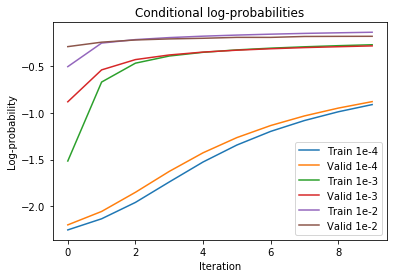

In [27]:
# plot the train and validation logp for all three learning rates in one figure

# YOUR CODE HERE
plt.plot(np.arange(10), logp_train1, label = 'Train 1e-4')
plt.title('Conditional log-probabilities')
plt.plot(np.arange(10), logp_valid1, label = 'Valid 1e-4')
plt.plot(np.arange(10), logp_train2, label = 'Train 1e-3')
plt.plot(np.arange(10), logp_valid2, label = 'Valid 1e-3')
plt.plot(np.arange(10), logp_train3, label = 'Train 1e-2')
plt.plot(np.arange(10), logp_valid3, label = 'Valid 1e-2')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.ylabel('Log-probability')
plt.show();

In [28]:
def plot_v_weights(data, num_cols, shape=(28,28)):
    num_rows = int(20 / num_cols)
    plt.figure(figsize=(15, 15))
    for i in range(20):
        plt.subplot(num_rows, num_cols, i+1 )
        plt.imshow(data[:, i].reshape(shape), interpolation='none', cmap='RdPu')
        plt.colorbar()
        plt.axis('off')
        plt.title(str(i)+'-th column of V')
    plt.tight_layout()
    plt.show()
    
def get_weights(x_train, t_train, w, b, v, a, eta = 1e-2, show_weights = True):
    i = 0
    v_dict = {}
    while i < 10:
        _, w, b, v, a = sgd_iter(x_train, t_train, w, b, v, a, eta)
        if i == 0 or i == 4 or i == 9:
            v_dict[i] = v
            if show_weights:
                print('EPOCH  '+str(i))
                plot_v_weights(v, num_cols = 2,shape=(28,28))
        i += 1
    return v_dict    

In [30]:
#  the best model - with  eta = 1e-2
v_dict = get_weights(x_train, t_train, w, b, v, a, eta = 1e-2, show_weights = False)

EPOCH  0


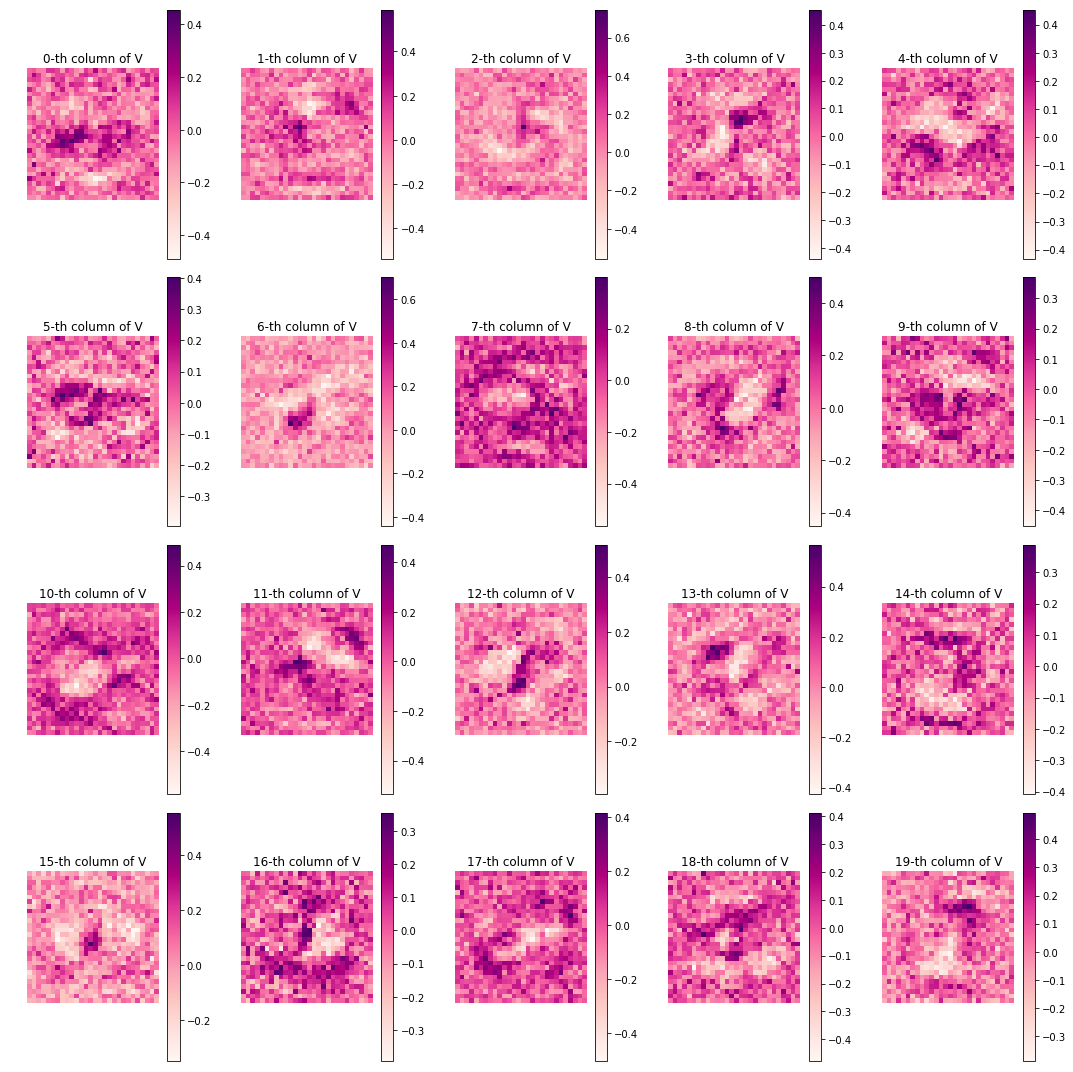

In [31]:
print('EPOCH  '+str(0))
plot_v_weights(v_dict[0], num_cols = 5,shape=(28,28))

EPOCH  4


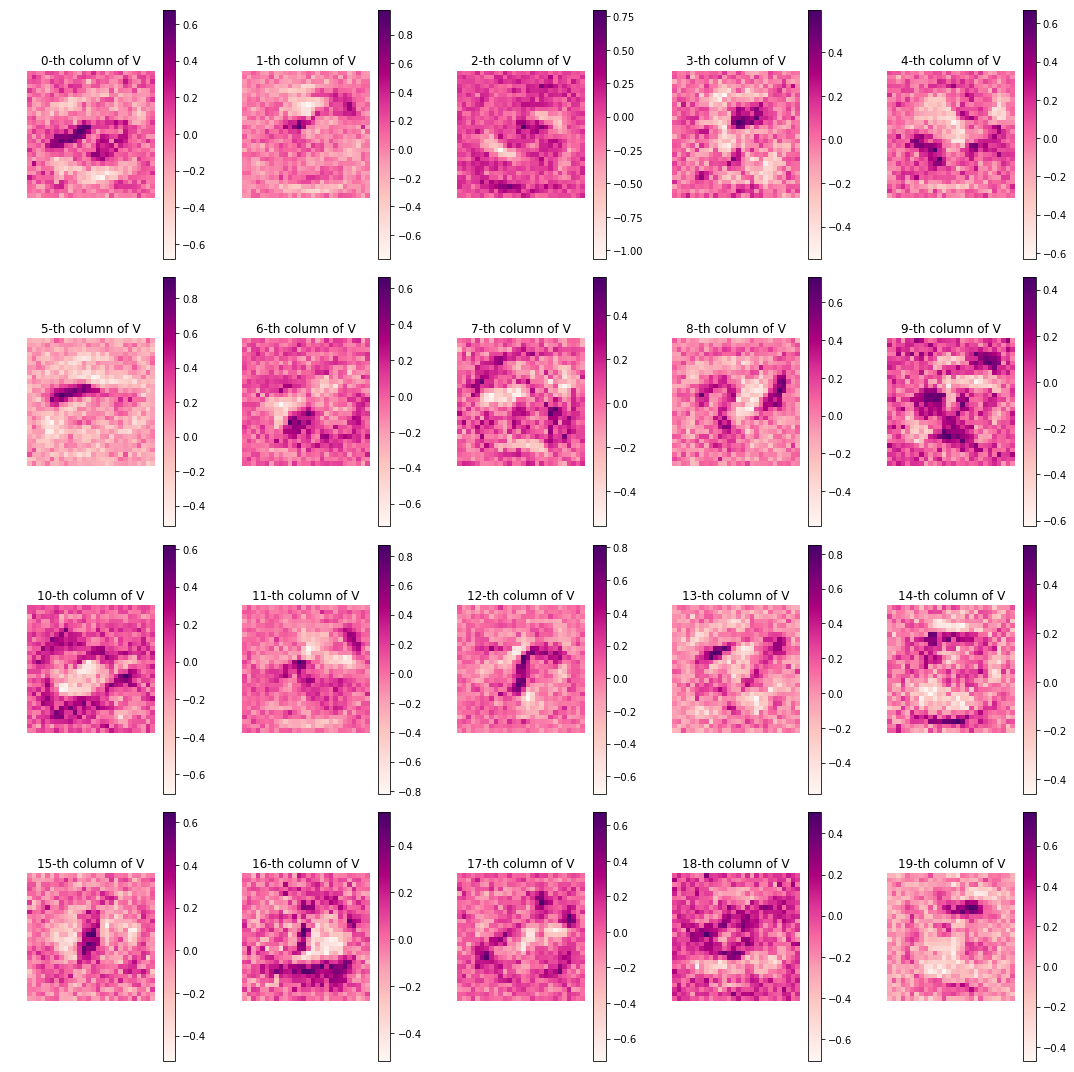

In [32]:
print('EPOCH  '+str(4))
plot_v_weights(v_dict[4], num_cols = 5,shape=(28,28))

EPOCH  9


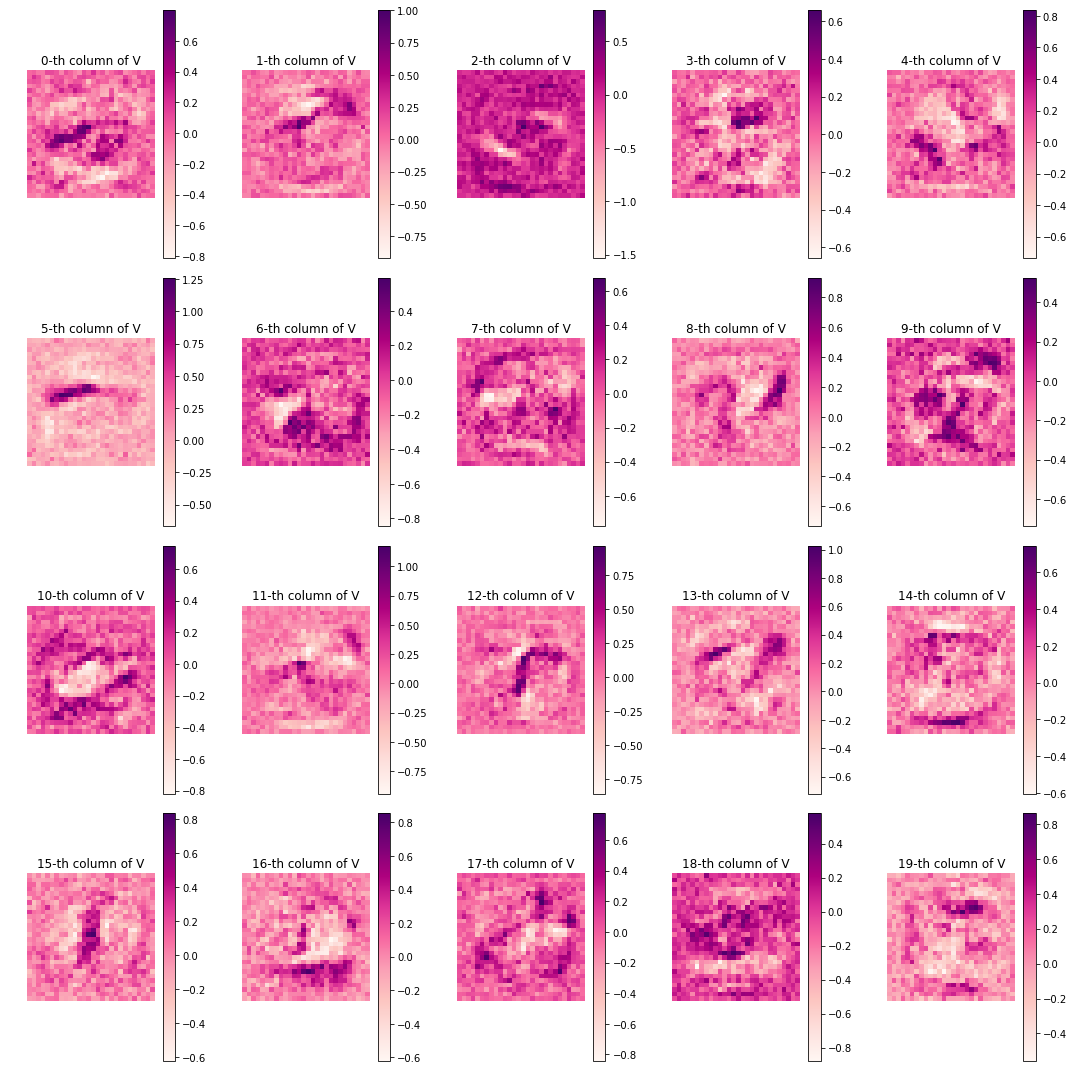

In [33]:
print('EPOCH  '+str(9))
plot_v_weights(v_dict[9], num_cols = 5,shape=(28,28))

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

#### YOUR ANSWER HERE
The bigger learning rate we set the bigger steps our learning algorithm takes resulting in faster improvement (especially during first couple steps) in terms of the number of iterations. After certain point all three models should converge to the certain level of evaluation quality meaning convergence to a local optimum. The task said to perform learning for 10 epochs. That's why learning rate of 1e-4 reached the level of performance that is lower than the level of performance of other options proving the fact of slower convergence, but not the worse overall performance.

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Weights V of the best model (eta = 1e-2)


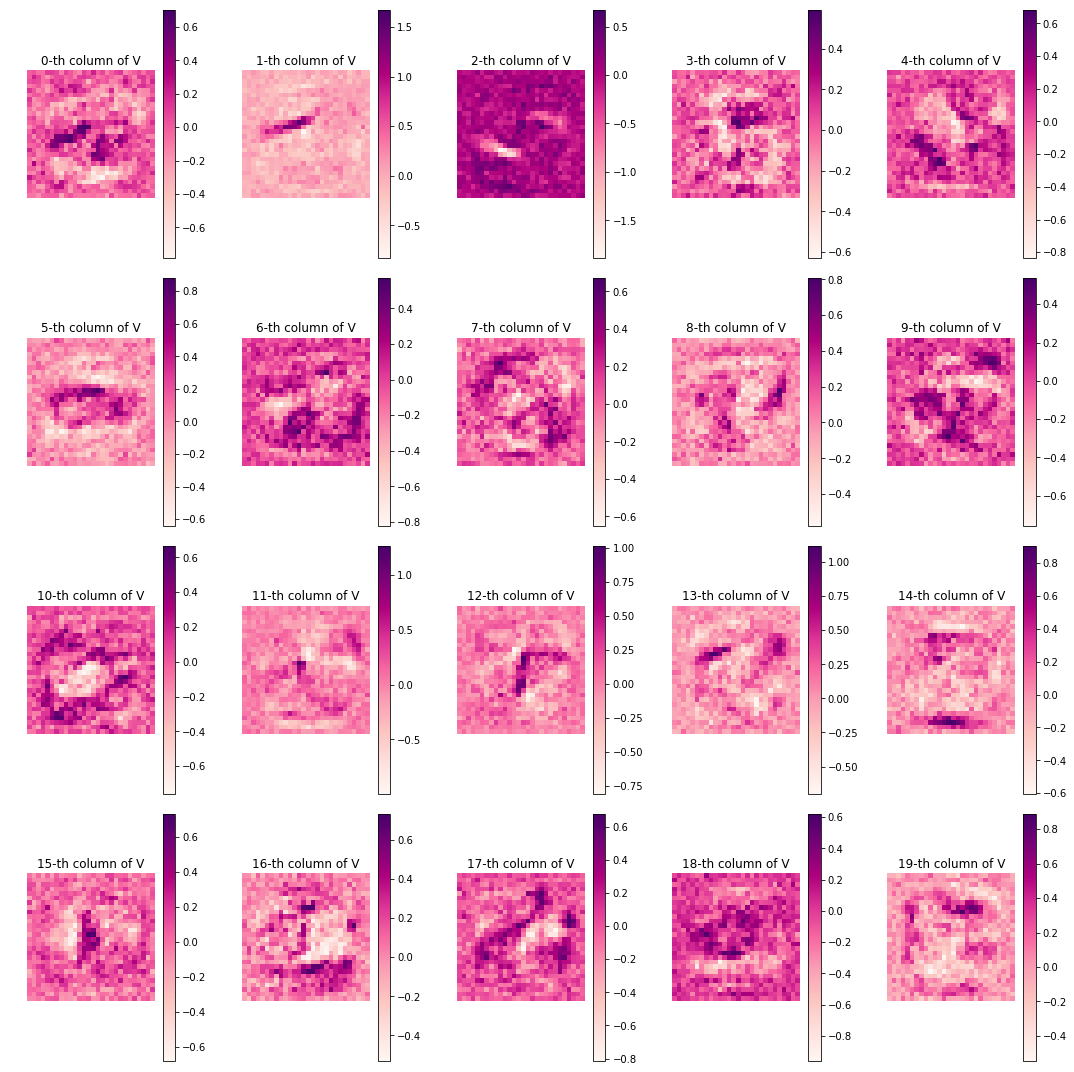

In [34]:
# Plot the weights of the first layer for the best model 

# YOUR CODE HERE
print('Weights V of the best model (eta = 1e-2)')
plot_v_weights(v3, num_cols = 5,shape=(28,28))

#### YOUR ANSWER HERE
Weights of the logistic regression captured explicit patterns which represent each class. Because MLP works better at capturing non-linear dependencies than simple logistic regression, the weights of the hidden layer are capturing not so obvious structures in the data, and by combining this hidden structures for the prediction the algorithm can get higher accuracy.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

#### YOUR ANSWER HERE
$$ \frac{\partial{\max(0.,x)}}{\partial x} = \begin{cases}
1, x > 0.\\
0., x < 0.
\end{cases}$$

$$\frac{\partial{\tanh(x)}}{\partial x} = \frac{\partial \frac{\sinh(x)}{\cosh(x)}}{\partial x} = \frac{\cosh(x)\frac{\partial\sinh(x)}{\partial x} - \sinh(x)\frac{\partial\cosh(x)}{\partial x}}{\cosh^2{x}} = \frac{\cosh(x)\cosh(x) - \sinh(x)\sinh(x)}{\cosh^2{x}} = 1 - \tanh^2(x)$$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

#### YOUR ANSWER HERE
1) The function should be differntiable almost everywhere and its derivatives and the activation function itself should be easily computed.

It is important because it could speed up the proccess of learning and ensures that gradient methods could be applied for optimization.

2) Avoids vanishing/exploding gradients problem.

With an inappropriate choice of an activation function we can encounter the vanishing/exploding gradients problem, which is an obstacle for a good optimization.

In [35]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

# YOUR CODE HERE
def relu(x):
    return np.maximum(0, x)

def drelu(x):
    d = [0 if i < 0 else 1 for i in x]
    return d

def dtanh(x):
    return 1 - np.tanh(x)**2

x = np.linspace(-3, 3, 1000)

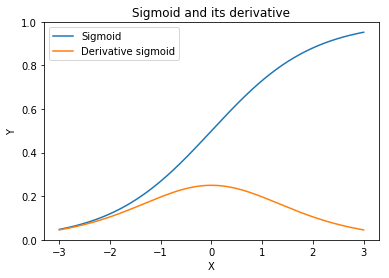

In [36]:
plt.title('Sigmoid and its derivative')
plt.plot(x, sigmoid(x), label = 'Sigmoid')
plt.plot(x, dsigmoid(x), label = 'Derivative sigmoid')
plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('Y')
plt.show();

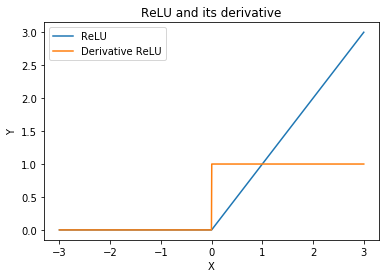

In [37]:
plt.title('ReLU and its derivative')
plt.plot(x, relu(x), label = 'ReLU')
plt.plot(x, drelu(x), label = 'Derivative ReLU')
plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('Y')
plt.show();

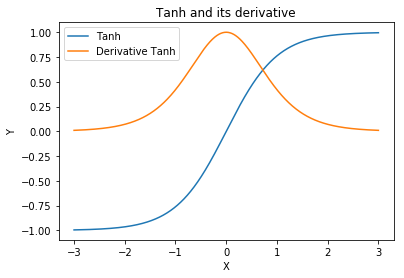

In [38]:
plt.title('Tanh and its derivative')
plt.plot(x, np.tanh(x), label = 'Tanh')
plt.plot(x, dtanh(x), label = 'Derivative Tanh')
plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('Y')
plt.show();

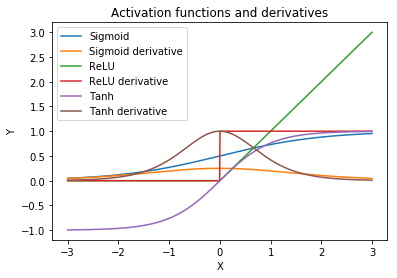

In [39]:
plt.title('Activation functions and derivatives')
plt.plot(x, sigmoid(x), label = 'Sigmoid')
plt.plot(x, dsigmoid(x), label = 'Sigmoid derivative')
plt.plot(x, relu(x), label = 'ReLU')
plt.plot(x, drelu(x), label = 'ReLU derivative')
plt.plot(x, np.tanh(x), label = 'Tanh')
plt.plot(x, dtanh(x), label = 'Tanh derivative')

plt.legend(loc='best')
plt.xlabel('X')
plt.ylabel('Y')
plt.show();

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

#### YOUR ANSWER HERE
We think that every activation could be useful depending on the architecture of the NN, the layer and the specific problem it is applied to, so the notion of 'the best' is relative. But if we were to use the activation function, suffices all important properties we have mentioned in the question 2.3.2., we would choose ReLU. It is differentiable almost everywhere, could be easily computed and most important it can address the problem of vanishing gradients.

In [40]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 12.9 minutes.
